In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np

In [2]:
with open("../data/affix_stats.pkl", "rb") as fin:
    affix_stats = pickle.load(fin)

In [38]:
list(affix_stats.values())[0].keys()

dict_keys(['Jtgt_sample', 'Jtgt_pval', 'Jtgt_rand_scores', 'Jctr_sample', 'Jctr_pval', 'Jctr_rand_scores', 'pred_sample', 'pred_pval', 'pred_rand_scores', 'tenc_sample', 'tenc_pval', 'tenc_rand_scores', 'tencCtr_sample', 'tencCtr_pval', 'tencCtr_rand_scores', 'bertCtr_sample', 'bertCtr_pval', 'bertCtr_rand_scores'])

In [210]:
from matplotlib import collections as mc



def plot_effect_strip(target_var, title, ax):
    lines = []
    points = []    
    for i, (char, stat_item) in enumerate(affix_stats.items()):        
        sample_score = stat_item[f"{target_var}_sample"]
        rand_scores = stat_item[f"{target_var}_rand_scores"]
        if not rand_scores: continue
        Q05, Q95 = np.quantile(rand_scores, [.05,.95])    
        color = "#e41a1c" if sample_score > Q95 else "#377eb8"
        points.append((i, sample_score, color))    
        lines.append([(i, Q05), (i, Q95)])    
    lc = mc.LineCollection(lines, color="#cccccc")
    ax.add_collection(lc)
    px, py, pcolors = list(zip(*points))
    ax.scatter(px, py, c=pcolors, s=2, zorder=10)
    # ax.set_ylim([-0.2,0.2])
    ax.autoscale()
    if target_var.startswith("J"):
        ax.set_ylim([-0.2,0.25])            
    
    ax.margins(0)
    ax.set_title(title, x=0.01, y=0.8, ha="left", fontsize=14)


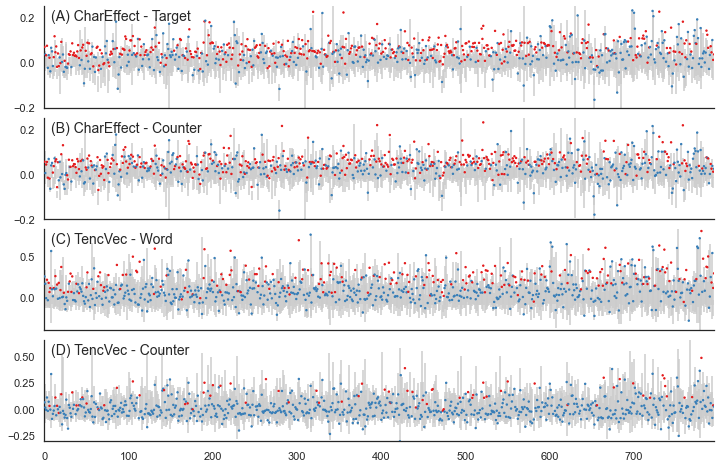

In [211]:
fig, ax = plt.subplots(4, 1, figsize=(12,8))
fig.subplots_adjust(hspace=0.1)
plot_effect_strip("Jtgt", "(A) CharEffect - Target", ax[0])
plot_effect_strip("Jctr", "(B) CharEffect - Counter", ax[1])
plot_effect_strip("pred", "(C) TencVec - Word", ax[2])
plot_effect_strip("tencCtr", "(D) TencVec - Counter", ax[3])
for i in range(3):
    ax[i].set_xticklabels([])
for i in range(len(ax)):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
fig.savefig("30.22-affix-series.png", dpi=300)

## Pval scores

In [135]:
import pandas as pd
char_frame_data = []
for char, stat_item in affix_stats.items():
    char_frame_data.append(dict(
        char=char,
        Jtgt_pval=stat_item["Jtgt_pval"],
        Jctr_pval=stat_item["Jctr_pval"],
        pred_pval=stat_item["pred_pval"],
        tenc_pval=stat_item["tenc_pval"],
        tencCtr_pval=stat_item["tencCtr_pval"],
        bertCtr_pval=stat_item["bertCtr_pval"],
    ))
char_frame = pd.DataFrame.from_records(char_frame_data).set_index("char")
char_frame = char_frame.rename(columns=dict(
    Jtgt_pval="CharEffect-Target", 
    Jctr_pval="CharEffect-Counter", 
    pred_pval="PredVec-Word", 
    tenc_pval="TencVec-Word",
    tencCtr_pval="TencVec-Counter", 
    bertCtr_pval="InputEmb-Counter"))
char_long = pd.melt(char_frame, var_name="variable", value_name="pval")

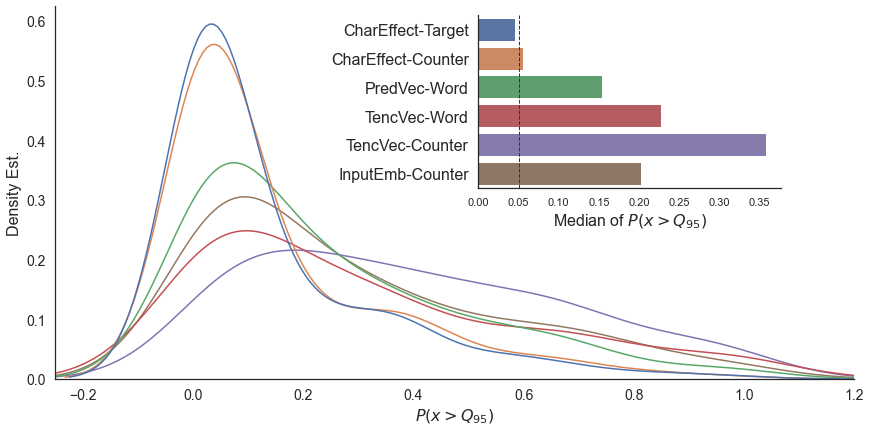

In [214]:
import seaborn as sns
scores = char_frame.median()
sns.set_style("white")
dp = sns.displot(char_long, x="pval", hue="variable", 
            kind="kde", bw_adjust=1.5, legend=False,
            height=6, aspect=2)
dp_ax = dp.axes[0][0]
dp_ax.tick_params(axis="both", color="black", labelsize=14)
dp_ax.set_xlim(-0.25,1.2)
dp_ax.set_xlabel("$P(x>Q_{95})$", fontsize=16)
dp_ax.set_ylabel("Density Est.", fontsize=16)

ax = plt.gcf().add_axes([0.55,0.55,0.35,0.4])
sns.barplot(x=scores, y=scores.index, 
            ax=ax)
ax.set_xlabel("Median of $P(x>Q_{95})$")
ax.axvline(0.05, color="#333333", linestyle="--", linewidth=1)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
sns.despine()
plt.gcf().savefig("30.22-affix-pval-distr.png", dpi=300)

<Figure size 1080x576 with 0 Axes>